In [1]:
# Imports

import sys
import subprocess


def _pip_install(pkg):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
    except Exception as e:
        print(f"Could not install {pkg}: {e}")


# Core
try:
    import pandas as pd
except ImportError:
    _pip_install("pandas>=2.0.0")
    import pandas as pd


try:
    import numpy as np
except ImportError:
    _pip_install("numpy>=1.24.0")
    import numpy as np


# Viz
try:
    import matplotlib.pyplot as plt
except ImportError:
    _pip_install("matplotlib>=3.7.0")
    import matplotlib.pyplot as plt


try:
    import seaborn as sns
except ImportError:
    _pip_install("seaborn>=0.13.0")
    import seaborn as sns

In [2]:
import pandas as pd

# dataset
df = pd.read_csv('/content/Career_Switch_Prediction_Dataset.csv')

display(df.head())

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,will_change_career
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,0,83,0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,0,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


In [3]:
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
    )
    from sklearn.cluster import KMeans
except ImportError:
    _pip_install("scikit-learn>=1.3.0")
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
    )
    from sklearn.cluster import KMeans


# Imbalance
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    _pip_install("imbalanced-learn>=0.12.0")
    from imblearn.over_sampling import SMOTE

In [5]:
_TF_AVAILABLE = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
except Exception:
    _TF_AVAILABLE = False

In [7]:
# Config, Utility

DATA_PATH = "Career_Switch_Prediction_Dataset.csv"
TARGET = "will_change_career" #0/1
RANDOM_STATE = 42


plt.rcParams.update({"figure.dpi": 120})


# Ordinal encodings for specific columns (based on dataset semantics)
EXP_ORDER = ['<1', '1','2','3','4','5','6','7','8','9','10',
'11','12','13','14','15','16','17','18','19','20','>20']
EXP_MAP = {v:i for i, v in enumerate(EXP_ORDER)}


NEW_JOB_ORDER = ['never','0','1','2','3','4','>4']
NEW_JOB_MAP = {v:i for i, v in enumerate(NEW_JOB_ORDER)}


# Convert company_size range to midpoint (approx)
import re


def size_to_num(s: str):
    if not isinstance(s, str) or s.strip() == "":
        return np.nan
    s = s.strip().replace(' ', '') # whitespace
    if s == '<10':
        return 5.0
    if s == '10/49' or s == '10-49':
        return 29.5 # (10+49)/2
    if s == '50-99':
        return 74.5 # (50+99)/2
    if s == '10000+':
        return 10000.0 # or some large number, using 10000 as lower bound
    m = re.match(r"(\d+)-(\d+)", s)
    if m:
        a = int(m.group(1))
        b = int(m.group(2))
        return (a + b) / 2.0
    m = re.match(r"(\d+)\+", s)
    if m:
        return float(m.group(1))
    try:
        return float(s)
    except ValueError:
        pass
    return np.nan

In [10]:
#Load

df = pd.read_csv(DATA_PATH)
print("Rows, Columns:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

print(df.describe(include='all').transpose())


n_features = df.shape[1] - 1 # excluding target
print(f"Number of features (excluding target): {n_features}")

n_points = len(df)
print(f"Number of data points: {n_points}")


# types
num_cols_raw = df.select_dtypes(include=['number']).columns.tolist()
cat_cols_raw = df.select_dtypes(exclude=['number']).columns.tolist()


print("\nNumeric columns (raw):", num_cols_raw)
print("Categorical columns (raw):", cat_cols_raw)

#EDA: Target Imbalance & Basic Plots

print("\nTarget Distribution")
print(df[TARGET].value_counts())

Rows, Columns: (5000, 14)
Columns: ['enrollee_id', 'city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours', 'will_change_career']
   enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   

  major_discipline experience company_size company_type last_new_job  \
0             STEM        >20          NaN          NaN            1   
1             STEM         15        50-99      Pvt Ltd           >4   


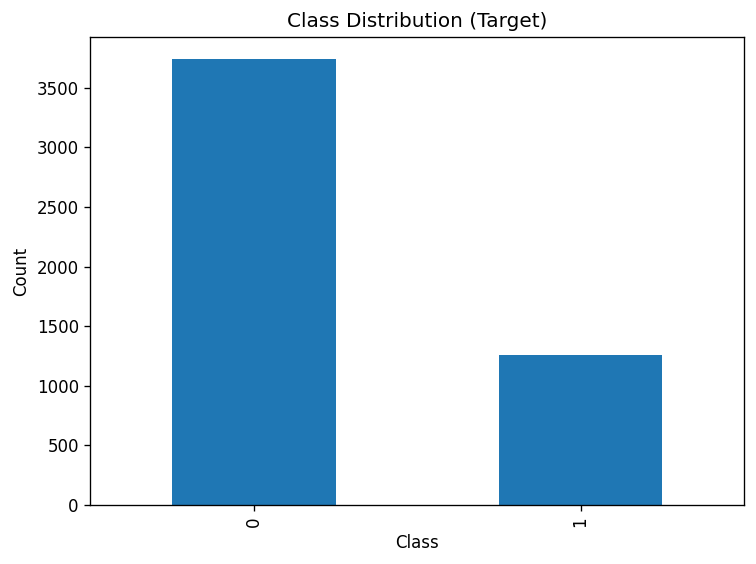

In [11]:
ax = df[TARGET].value_counts().sort_index().plot(kind='bar')
plt.title('Class Distribution (Target)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

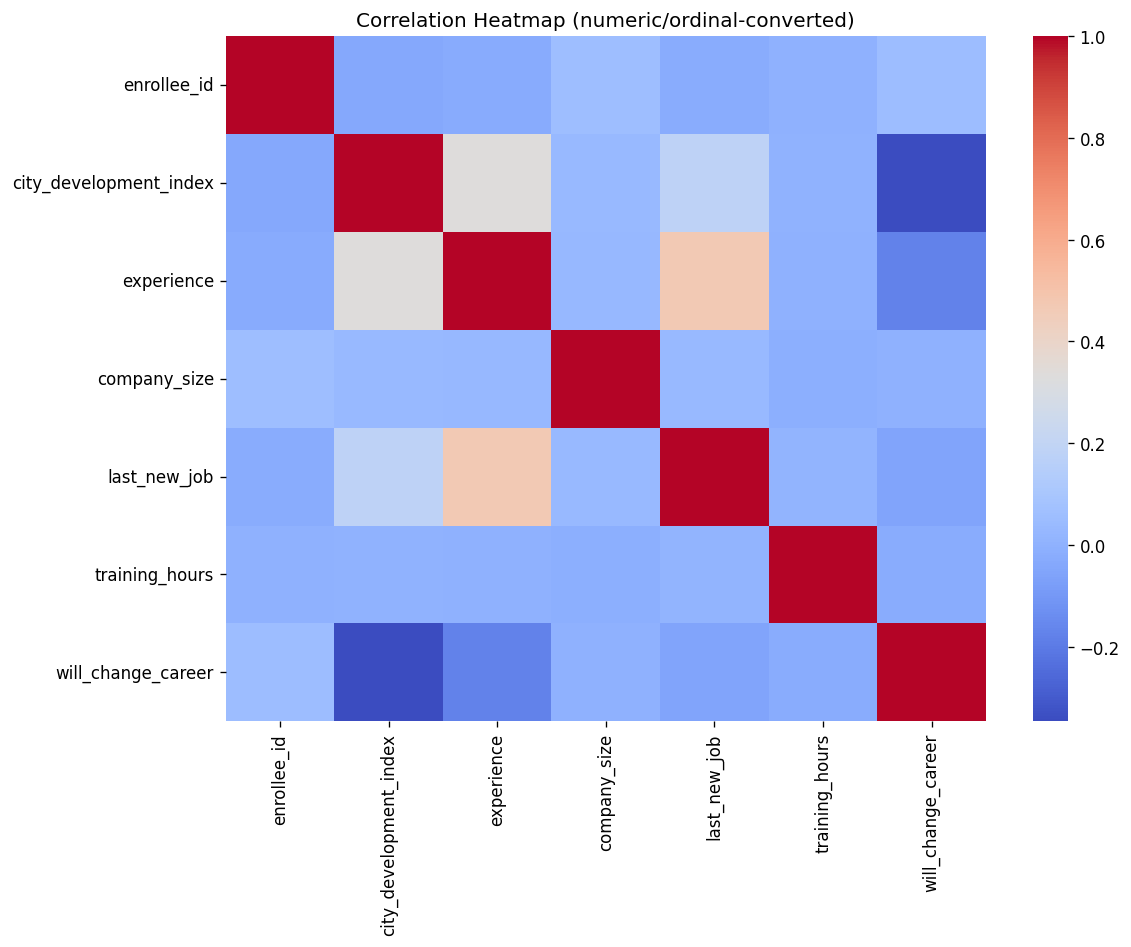

In [13]:
# Correlation heatmap over numeric features (including target)
# We'll convert a copy with ordinal mappings to include certain string columns.

eda_df = df.copy()
if 'experience' in eda_df.columns:
    eda_df['experience'] = eda_df['experience'].map(EXP_MAP)
if 'last_new_job' in eda_df.columns:
    eda_df['last_new_job'] = eda_df['last_new_job'].map(NEW_JOB_MAP)
if 'company_size' in eda_df.columns:
    eda_df['company_size'] = eda_df['company_size'].apply(size_to_num)


num_for_corr = eda_df.select_dtypes(include='number')
plt.figure(figsize=(10, 8))
sns.heatmap(num_for_corr.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap (numeric/ordinal-converted)')
plt.tight_layout()
plt.show()

In [15]:
#Data Cleaning & Preprocessing

print("\n=== Missing values per column ===\n", df.isnull().sum())


# Drop obvious identifier
drop_cols = []
if 'enrollee_id' in df.columns:
    drop_cols.append('enrollee_id')


X = df.drop(columns=[TARGET] + drop_cols)
y = df[TARGET].astype(int)


# columns for special ordinal/numeric handling
ordinal_cols = []
if 'experience' in X.columns:
    ordinal_cols.append('experience')
if 'last_new_job' in X.columns:
    ordinal_cols.append('last_new_job')


numeric_cols = []
# numeric as-is
for c in X.select_dtypes(include=['number']).columns:
    if c not in ordinal_cols:
        numeric_cols.append(c)


# company_size as ordinal numeric by conversion
if 'company_size' in X.columns:
    ordinal_cols.append('company_size')


# remaining categorical
categorical_cols = [c for c in X.columns if c not in numeric_cols + ordinal_cols]


print("\nPlanned column groups:")
print("numeric_cols:", numeric_cols)
print("ordinal_cols:", ordinal_cols)
print("categorical_cols:", categorical_cols)


=== Missing values per column ===
 enrollee_id                  0
city                         0
city_development_index       0
gender                    1113
relevent_experience          0
enrolled_university        107
education_level            118
major_discipline           724
experience                  11
company_size              1571
company_type              1621
last_new_job               104
training_hours               0
will_change_career           0
dtype: int64

Planned column groups:
numeric_cols: ['city_development_index', 'training_hours']
ordinal_cols: ['experience', 'last_new_job', 'company_size']
categorical_cols: ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_type']


In [16]:
# Transformers

def ordinal_mapper(X_):

    if not isinstance(X_, pd.DataFrame):
        X_ = pd.DataFrame(X_, columns=ordinal_cols)

    processed_df = pd.DataFrame()
    for col in X_.columns:
        if col == 'experience':
            processed_df[col] = X_[col].map(EXP_MAP)
        elif col == 'last_new_job':
            processed_df[col] = X_[col].map(NEW_JOB_MAP)
        elif col == 'company_size':
            processed_df[col] = X_[col].apply(size_to_num)
        else:
            processed_df[col] = pd.to_numeric(X_[col], errors='coerce')
    return processed_df


ordinal_transformer = Pipeline(steps=[
("imputer", SimpleImputer(strategy="most_frequent")),
("mapper",
__import__('sklearn').preprocessing.FunctionTransformer(
    func=ordinal_mapper,
    validate=False
)
),
("imputer2", SimpleImputer(strategy="median")),
("scaler", StandardScaler())
])


numeric_transformer = Pipeline(steps=[
("imputer", SimpleImputer(strategy="median")),
("scaler", StandardScaler())
])


categorical_transformer = Pipeline(steps=[
("imputer", SimpleImputer(strategy="most_frequent")),
("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(
transformers=[
("num", numeric_transformer, numeric_cols),
("ord", ordinal_transformer, ordinal_cols),
("cat", categorical_transformer, categorical_cols),
],
remainder='drop'
)

In [18]:

#Split & SMOTE

X_train_full, X_test, y_train_full, y_test = train_test_split(
X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
# 10% of total for validation from remaining 80% -> 12.5% of train_full
X_train, X_val, y_train, y_val = train_test_split(
X_train_full, y_train_full, test_size=0.125, random_state=RANDOM_STATE, stratify=y_train_full
)

preprocessor.fit(X_train)

X_train_t = preprocessor.transform(X_train)
X_val_t = preprocessor.transform(X_val)
X_test_t = preprocessor.transform(X_test)


print(X_train_t.shape, X_val_t.shape, X_test_t.shape)

smote = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = smote.fit_resample(X_train_t, y_train)
print("After SMOTE class counts:", np.bincount(y_train_bal))

feature_names = []
try:
    feature_names = preprocessor.get_feature_names_out()
except Exception:
    feature_names = [f"f{i}" for i in range(X_train_t.shape[1])]

(3500, 137) (500, 137) (1000, 137)
After SMOTE class counts: [2616 2616]


In [20]:
models = {}

if _TF_AVAILABLE:
    nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_bal.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
    ])
    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("\nNeural Network")
    nn_model.fit(X_train_bal, y_train_bal, validation_data=(X_val_t, y_val),
    epochs=50, batch_size=64, verbose=1)
    y_prob_nn = nn_model.predict(X_test_t).ravel()
    y_pred_nn = (y_prob_nn >= 0.5).astype(int)
    models['Neural Network'] = (y_pred_nn, y_prob_nn)


print("\nLogistic Regression")
log_model = LogisticRegression(max_iter=1000, n_jobs=None)
log_model.fit(X_train_bal, y_train_bal)
y_prob_log = log_model.predict_proba(X_test_t)[:, 1]
y_pred_log = (y_prob_log >= 0.5).astype(int)
models['Logistic Regression'] = (y_pred_log, y_prob_log)


print("\nDecision Tree")
tree_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_model.fit(X_train_bal, y_train_bal)
y_prob_tree = tree_model.predict_proba(X_test_t)[:, 1]
y_pred_tree = (y_prob_tree >= 0.5).astype(int)
models['Decision Tree'] = (y_pred_tree, y_prob_tree)


print("\nKNN (k=7)")
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train_bal, y_train_bal)
y_prob_knn = knn_model.predict_proba(X_test_t)[:, 1]
y_pred_knn = (y_prob_knn >= 0.5).astype(int)
models['KNN'] = (y_pred_knn, y_prob_knn)


Neural Network
Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6302 - loss: 0.6411 - val_accuracy: 0.7780 - val_loss: 0.5422
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7304 - loss: 0.5487 - val_accuracy: 0.7460 - val_loss: 0.5501
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7469 - loss: 0.5254 - val_accuracy: 0.6940 - val_loss: 0.6180
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7586 - loss: 0.5110 - val_accuracy: 0.7100 - val_loss: 0.5971
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7883 - loss: 0.4710 - val_accuracy: 0.7240 - val_loss: 0.5597
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7913 - loss: 0.4603 - val_accuracy: 0.6940 - val_loss: 0.6218
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7962 - loss: 0.4517 - val_accuracy: 0.6920 - val_loss: 0.6594
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8003 - loss: 0.4467 - val_accuracy: 0

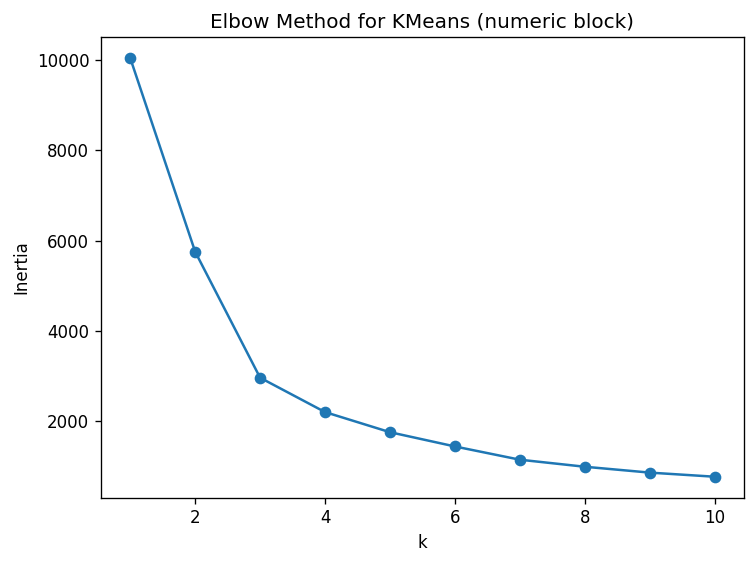

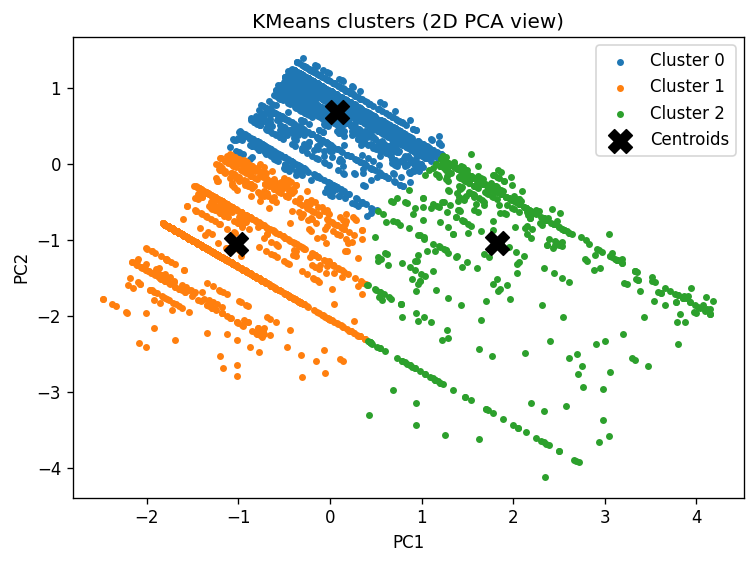


Cluster sizes:
 cluster
0    3027
1    1343
2     630
Name: count, dtype: int64
Mean target per cluster (prevalence of class=1):
 cluster
0    0.166171
1    0.474311
2    0.193651
Name: y, dtype: float64


In [21]:
# Unsupervised (KMeans)
from sklearn.decomposition import PCA

numeric_block = preprocessor.named_transformers_['num'].transform(X.select_dtypes(include=['number']))

if numeric_block.shape[1] >= 2:
    inertia = []
    for k in range(1, 11):
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        km.fit(numeric_block)
        inertia.append(km.inertia_)


    plt.figure()
    plt.plot(range(1, 11), inertia, marker='o')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for KMeans (numeric block)')
    plt.tight_layout()
    plt.show()


    kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(numeric_block)


    # 2D PCA for visualization
    pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
    coords = pca2.fit_transform(numeric_block)
    plt.figure()
    for c in np.unique(clusters):
        plt.scatter(coords[clusters==c, 0], coords[clusters==c, 1], label=f'Cluster {c}', s=10)
    plt.scatter(pca2.transform(kmeans.cluster_centers_)[:,0], pca2.transform(kmeans.cluster_centers_)[:,1],
    marker='X', s=200, c='black', label='Centroids')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('KMeans clusters (2D PCA view)')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Compare class prevalence across clusters
    tmp = pd.DataFrame({'cluster': clusters, 'y': y})
    print("\nCluster sizes:\n", tmp['cluster'].value_counts())
    print("Mean target per cluster (prevalence of class=1):\n", tmp.groupby('cluster')['y'].mean())
else:
    print("Not enough numeric features for KMeans visualization.")


=== Neural Network ===
              precision    recall  f1-score   support

           0       0.82      0.75      0.79       748
           1       0.41      0.51      0.46       252

    accuracy                           0.69      1000
   macro avg       0.62      0.63      0.62      1000
weighted avg       0.72      0.69      0.70      1000



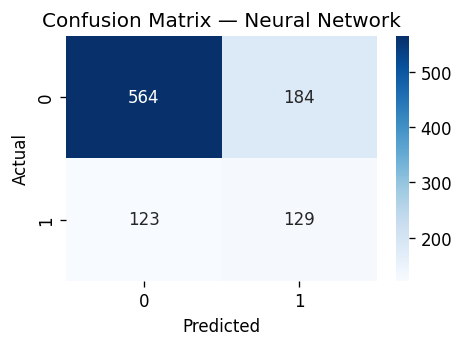


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       748
           1       0.44      0.62      0.52       252

    accuracy                           0.71      1000
   macro avg       0.65      0.68      0.65      1000
weighted avg       0.75      0.71      0.72      1000



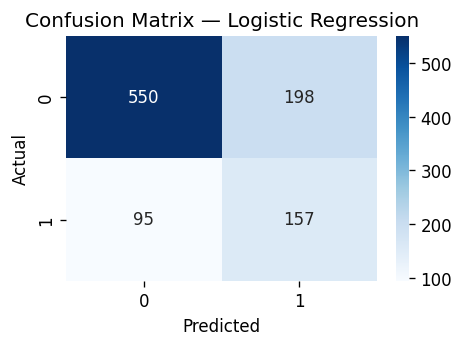


=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       748
           1       0.42      0.46      0.44       252

    accuracy                           0.70      1000
   macro avg       0.61      0.62      0.62      1000
weighted avg       0.71      0.70      0.71      1000



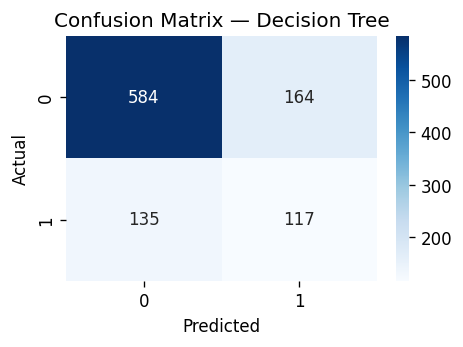


=== KNN ===
              precision    recall  f1-score   support

           0       0.84      0.57      0.68       748
           1       0.35      0.68      0.46       252

    accuracy                           0.60      1000
   macro avg       0.59      0.62      0.57      1000
weighted avg       0.72      0.60      0.62      1000



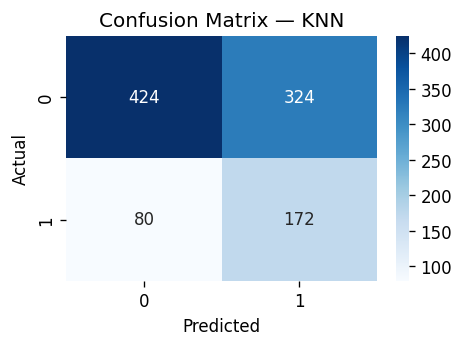

In [22]:
# Evaluation & Comparison

metrics_table = []


for name, (y_pred, y_prob) in models.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_prob)
    except Exception:
        auc = np.nan


    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, zero_division=0))


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix — {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


    metrics_table.append({
    'Model': name,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1': f1,
    'AUC': auc
    })

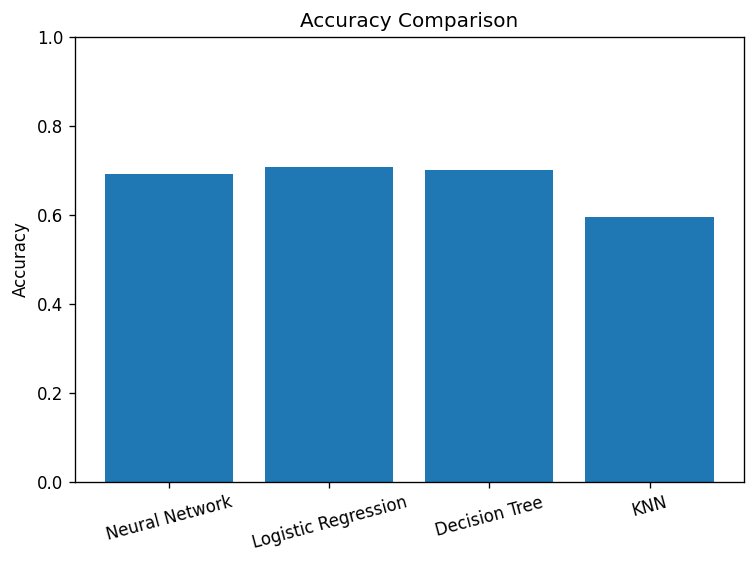

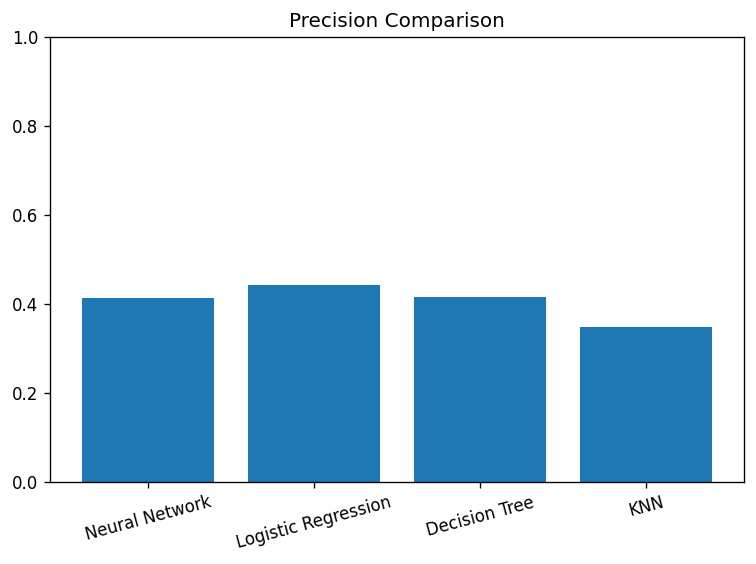

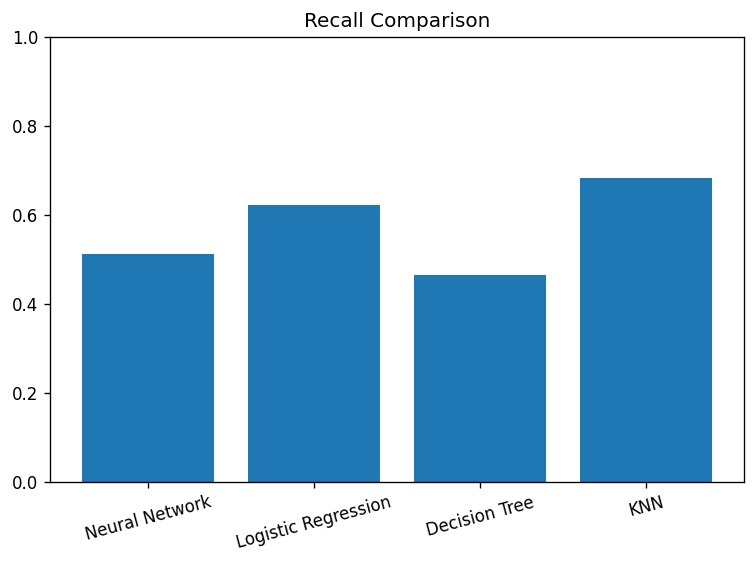

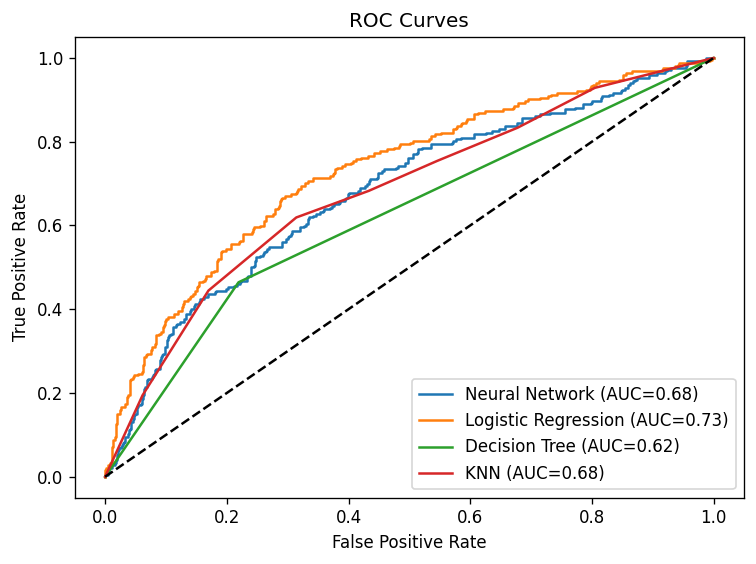

In [23]:
# Bar chart of accuracy
accs = {m['Model']: m['Accuracy'] for m in metrics_table}
plt.figure()
plt.bar(list(accs.keys()), list(accs.values()))
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.ylim(0,1)
plt.tight_layout()
plt.show()


# Precision & Recall comparison
precs = {m['Model']: m['Precision'] for m in metrics_table}
recs = {m['Model']: m['Recall'] for m in metrics_table}


plt.figure()
plt.bar(list(precs.keys()), list(precs.values()))
plt.title('Precision Comparison')
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


plt.figure()
plt.bar(list(recs.keys()), list(recs.values()))
plt.title('Recall Comparison')
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# ROC Curves
plt.figure()
for name, (y_pred, y_prob) in models.items():
    try:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.2f})')
    except Exception:
        pass

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
#Summary

metrics_df = pd.DataFrame(metrics_table).sort_values('Accuracy', ascending=False)
print("\n=== Model Comparison (Test Set) ===\n", metrics_df)
# CSV
metrics_df.to_csv('model_metrics_comparison.csv', index=False)


=== Model Comparison (Test Set) ===
                  Model  Accuracy  Precision    Recall        F1       AUC
1  Logistic Regression     0.707   0.442254  0.623016  0.517298  0.729756
2        Decision Tree     0.701   0.416370  0.464286  0.439024  0.622517
0       Neural Network     0.693   0.412141  0.511905  0.456637  0.680274
3                  KNN     0.596   0.346774  0.682540  0.459893  0.680585


In [30]:
# Project Information

def extract_project_info(df, target, metrics_df, y):
    info = {}

    # Dataset basics
    info['num_rows'], info['num_cols'] = df.shape
    info['num_features'] = df.shape[1] - 1
    info['target'] = target
    info['problem_type'] = "Classification (binary)" if len(df[target].unique()) == 2 else "Other"

    # Class distribution
    class_counts = df[target].value_counts().to_dict()
    info['class_distribution'] = class_counts

    # Feature types
    num_cols = df.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    info['numeric_features'] = num_cols
    info['categorical_features'] = cat_cols

    # Best model (sorted by accuracy in metrics_df)
    best_row = metrics_df.sort_values('Accuracy', ascending=False).iloc[0]
    info['best_model'] = best_row['Model']
    info['best_accuracy'] = best_row['Accuracy']
    info['best_precision'] = best_row['Precision']
    info['best_recall'] = best_row['Recall']
    info['best_auc'] = best_row['AUC']

    # All model results
    info['all_models'] = metrics_df.to_dict(orient='records')

    return info

project_info = extract_project_info(df, TARGET, metrics_df, y)

import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(project_info)

import json
with open("project_info.json", "w") as f:
    json.dump(project_info, f, indent=2)


{ 'all_models': [ { 'AUC': 0.7297555385790679,
                    'Accuracy': 0.707,
                    'F1': 0.5172981878088962,
                    'Model': 'Logistic Regression',
                    'Precision': 0.4422535211267606,
                    'Recall': 0.623015873015873},
                  { 'AUC': 0.6225171886936594,
                    'Accuracy': 0.701,
                    'F1': 0.43902439024390244,
                    'Model': 'Decision Tree',
                    'Precision': 0.41637010676156583,
                    'Recall': 0.4642857142857143},
                  { 'AUC': 0.6802743824802647,
                    'Accuracy': 0.693,
                    'F1': 0.45663716814159294,
                    'Model': 'Neural Network',
                    'Precision': 0.41214057507987223,
                    'Recall': 0.5119047619047619},
                  { 'AUC': 0.6805847338935574,
                    'Accuracy': 0.596,
                    'F1': 0.45989304812834225,
           